In [71]:
from SimPEG.Utils import speye, kron3, sdiag, mkvc
from SimPEG import Mesh, Utils, Maps, PF, Regularization, Optimization, Directives, DataMisfit, InvProblem, Inversion
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt




In [72]:
from SimPEG import Utils
# Create block problem for gravity ... nothing new here you can skip to the next cell
# Magnetic inducing field parameter (A,I,D)


# Create a mesh
dx = 5.
npad = 0
hxind = [(dx, npad, -1.3), (dx, 51), (dx, npad, 1.3)]
hyind = [(dx, npad, -1.3), (dx, 51), (dx, npad, 1.3)]
hzind = [(dx, npad, -1.3), (dx, 31)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0[2] -= mesh.vectorNz[-1]

susc = 0.2
nX = 3

# Get index of the center of block
locx = [int(mesh.nCx/2)]#[int(mesh.nCx/2)-3, int(mesh.nCx/2)+3]
midy = int(mesh.nCy/2)
midz = -11

# Create and array of observation points
xr = np.linspace(-100, 100., 7)
yr = np.linspace(-100, 100., 7)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones_like(X) * mesh.vectorNz[-1] + dx

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseGrav.RxObs(xyzLoc)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
# Here a simple block in half-space
model = np.zeros((mesh.nCx, mesh.nCy, mesh.nCz))
for midx in locx:
    model[(midx-nX):(midx+nX+1), (midy-nX):(midy+nX+1), (midz-nX):(midz+nX+1)] = susc
model = Utils.mkvc(model)

actv = np.ones(mesh.nC, dtype='bool')

In [73]:
# Generate data
idenMap = Maps.IdentityMap(nP=mesh.nC)
prob = PF.Gravity.GravityIntegral(mesh, rhoMap = idenMap)
survey.pair(prob)

data = prob.fields(model)

survey.dobs = data
survey.std = np.ones(survey.nD)*1e-4
xyzLoc = survey.srcField.rxList[0].locs
ax = PF.Gravity.plot_obs_2D(xyzLoc,d=data)
plt.show()

Mesh.TensorMesh.writeUBC(mesh,'Mesh.msh')
Mesh.TensorMesh.writeModelUBC(mesh,'RotatedCube.den',model)
PF.Gravity.writeUBCobs('RotatedCube.obs',survey, data)

Begin linear forward calculation: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Linear forward calculation ended in: 1.8462302684783936 sec


AttributeError: module 'SimPEG.PF.Gravity' has no attribute 'plot_obs_2D'

In [ ]:
"""
TO LINDSEY:

This is the stuff I would like to get in the framework.
The getDiffOpRot function can probably be splitted in many sub-functions/properties
The strategy is:
    1- Rotate the x, y or z vectors (the usual forward or backward difference directions)
        along a different orientation specified by three angles (psi, theta, phi). 
        psi : Rotation around the x-axis 
        theta: Rotation around the y-axis 
        phi : Rotation around z-axis 
        
    2- Move the center of a unit block with the same orientation
    
    3- Calculate the partial volumes intersected with the unit block with the 26 blocks
        making a 3-by-3-by-3 stencil
    
    4- Construct a new forward or backward difference operator by summing up the contribution of 
        all non-zero operators of the 26-point stencil (+1 for the center block)
        
    5- Repeat for all three x, y and z gradient operators

    I created a little GUI at the bottom of the notebook for us to see what the gradients look like
    for different components and angles.
    
""" 


# def ddx(n,vals):
#     """Define 1D averaging operator from cell-centers to nodes."""
#     ddx = (
#         sp.sparse.spdiags(
#             (np.ones((n, 1)) * vals).T,
#             [-1, 0, 1],
#             n , n,
#             format="csr"
#         ) 
#     )
#     return ddx


# def getDiffOpRot(mesh, psi, theta, phi, vec, forward = True):
    
#     unitMesh = Mesh.TensorMesh([np.ones(3),np.ones(3),np.ones(3)], x0='CCC')
    
#     stencil = []
#     for ii in range(unitMesh.nC):
#         stencil += [np.kron(np.r_[-1,1],[0.5,0.5,0.5]).reshape((2,3)) + np.kron(np.ones(2),unitMesh.gridCC[ii,:]).reshape((2,3))]

#     if isinstance(theta, float):
#         theta = np.ones(mesh.nC) * theta
#     if isinstance(phi, float):
#         phi = np.ones(mesh.nC) * phi
#     if isinstance(psi, float):
#         psi = np.ones(mesh.nC) * psi

#     if forward:
#         ind = 1
#     else:
#         ind = -1
        
#     if vec=='X':
#         px = np.kron(np.ones(mesh.nC),np.c_[ind,0,0])
#     elif vec=='Y':
#         px = np.kron(np.ones(mesh.nC),np.c_[0,ind,0])
#     else:
#         px = np.kron(np.ones(mesh.nC),np.c_[0,0,ind])  

#     #     v = np.ones((mesh.nC,27))
#     #     for ii in range(mesh.nC):

#     # Create sparse rotation operators
#     rxa = mkvc(np.c_[np.ones(mesh.nC), np.cos(psi), np.cos(psi)].T)
#     rxb = mkvc(np.c_[np.zeros(mesh.nC), np.sin(psi),np.zeros(mesh.nC)].T)
#     rxc = mkvc(np.c_[np.zeros(mesh.nC), -np.sin(psi),np.zeros(mesh.nC)].T)
#     Rx = sp.sparse.diags([rxb[:-1],rxa,rxc[:-1]],[-1,0,1])

#     rya = mkvc(np.c_[np.cos(theta), np.ones(mesh.nC), np.cos(theta)].T)
#     ryb = mkvc(np.c_[-np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
#     ryc = mkvc(np.c_[np.sin(theta), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
#     Ry = sp.sparse.diags([ryb[:-2],rya,ryc[:-2]],[-2,0,2])

#     rza = mkvc(np.c_[np.cos(phi), np.cos(phi),np.ones(mesh.nC)].T)
#     rzb = mkvc(np.c_[np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
#     rzc = mkvc(np.c_[-np.sin(phi), np.zeros(mesh.nC), np.zeros(mesh.nC)].T)
#     Rz = sp.sparse.diags([rzb[:-1],rza,rzc[:-1]],[-1,0,1])

#     # Rotate all cell vectors
#     rx = (Rz*(Ry*(Rx*px.T))).reshape((mesh.nC,3))

#     # Move the bottom-SW and top-NE nodes
#     nBSW = np.kron(stencil[13][0],np.ones((mesh.nC,1)))+rx
#     nTNE = np.kron(stencil[13][1],np.ones((mesh.nC,1)))+rx

#     # Compute fractional volumes with base stencil
#     V=[]
#     for s in stencil:

#         sBSW = np.kron(s[0],np.ones((mesh.nC,1)))
#         sTNE = np.kron(s[1],np.ones((mesh.nC,1)))

#         V += [(np.max([np.min([sTNE[:, 0], nTNE[:, 0]])-np.max([sBSW[:, 0], nBSW[:, 0]]), 0]) *
#          np.max([np.min([sTNE[:, 1], nTNE[:, 1]])-np.max([sBSW[:, 1], nBSW[:, 1]]), 0]) * 
#          np.max([np.min([sTNE[:, 2], nTNE[:, 2]])-np.max([sBSW[:, 2], nBSW[:, 2]]), 0]))]

#     count = -1
#     Gx = speye(mesh.nC)

#     for ii in range(3):
#         flagz = [0,0,0]
#         flagz[ii] = 1

#         for jj in range(3):
#             flagy = [0,0,0]
#             flagy[jj] = 1

#             for kk in range(3):

#                 flagx = [0,0,0]
#                 flagx[kk] = 1

#                 count += 1
#                 Gx -= sdiag(np.ones(mesh.nC)*V[count])*kron3( ddx(mesh.nCz,flagz), ddx(mesh.nCy,flagy), ddx(mesh.nCx,flagx) )

#     return Gx

def ddx(n,vals):
    """Define 1D averaging operator from cell-centers to nodes."""
    ddx = (
        sp.sparse.spdiags(
            (np.ones((n, 1)) * vals).T,
            [-1, 0, 1],
            n , n,
            format="csr"
        ) 
    )
    return ddx

def Rz(theta):
    """Rotation matrix about z axis"""
    Rz = np.vstack((np.r_[np.cos((theta)),
                          -np.sin((theta)), 0],
                   np.r_[np.sin((theta)),
                         np.cos((theta)), 0],
                   np.r_[0, 0, 1]))
    return Rz
                          
def Ry(theta):
    """Rotation matrix about y axis"""
    Ry = np.vstack( (np.r_[np.cos((theta)), 0,
                     np.sin((theta))],
                   np.r_[0, 1, 0],
               np.r_[-np.sin((theta)), 0,
                     np.cos((theta))]))

    return Ry

def getDiffOpRot(mesh, psi, theta, phi, vec, forward=True):
    """Build gradient operator"""
    count = -1

    ry = Ry((-theta))

    rz = Rz((-phi))
    
    
    R = np.dot(rz,ry)
    
    
    D = sp.sparse.csr_matrix((mesh.nC, mesh.nC))

    if vec == 'X':
        axis =0
    elif vec == 'Y':
        axis =1
    else:
        axis =2

    for ii in range(3):
        count+=1
        flagx, flagy, flagz = [0, 1, 0], [0, 1, 0], [0, 1, 0]
        
        if forward:
            if ii == 0:
                flagx = [0, 1, -1]
            elif ii == 1:
                flagy = [0, 1, -1]    
            else:
                flagz = [0, 1, -1]
        else:
            if ii == 0:
                flagx = [-1, 1, 0]
            elif ii == 1:
                flagy = [-1, 1, 0]   
            else:
                flagz = [-1, 1, 0]


        D += sdiag(np.ones(mesh.nC)*R[axis,ii])*kron3( ddx(mesh.nCz,flagz), ddx(mesh.nCy,flagy), ddx(mesh.nCx,flagx) )
#         D += sdiag(np.ones(mesh.nC)*R[axis,ii])*kron3( ddx(mesh.nCz,flagz), ddx(mesh.nCy,flagy), ddx(mesh.nCx,flagx) )

    return D


In [ ]:
mrec=[]
theta = np.deg2rad(0.)
phi = np.deg2rad(45.)

xvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[1,0,0]))
yvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[0,1,0]))
zvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[0,0,1]))

norms = np.c_[0, 0.5, 0.5, 0.5]
indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), 0, 0, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.F.shape[1])
for ii in range(survey.nD):
    wr += (prob.F[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg1.norms = norms
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = xvec[0]*Dx1 + xvec[1]*Dy1 + xvec[2]*Dz1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = yvec[0]*Dx1 + yvec[1]*Dy1 + yvec[2]*Dz1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = zvec[0]*Dx1 + zvec[1]*Dy1 + zvec[2]*Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg2.norms = norms
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = xvec[0]*Dx2 + xvec[1]*Dy2 + xvec[2]*Dz2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = yvec[0]*Dx2 + yvec[1]*Dy2 + yvec[2]*Dz2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = zvec[0]*Dx2 + zvec[1]*Dy2 + zvec[2]*Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10, beta_tol=5e-1)
update_Jacobi = Directives.UpdateJacobiPrecond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec += [inv.run(m0)]

In [74]:
theta = np.deg2rad(0.)
phi = np.deg2rad(15.)

xvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[1,0,0]))
yvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[0,1,0]))
zvec = np.dot(Rz(theta), np.dot(Ry(phi), np.r_[0,0,1]))

norms = np.c_[0, 0.5, 0.5, 0.5]
indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.F.shape[1])
for ii in range(survey.nD):
    wr += (prob.F[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg1.norms = norms
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = xvec[0]*Dx1 + xvec[1]*Dy1 + xvec[2]*Dz1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = yvec[0]*Dx1 + yvec[1]*Dy1 + yvec[2]*Dz1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = zvec[0]*Dx1 + zvec[1]*Dy1 + zvec[2]*Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg2.norms = norms
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = xvec[0]*Dx2 + xvec[1]*Dy2 + xvec[2]*Dz2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = yvec[0]*Dx2 + yvec[1]*Dy2 + yvec[2]*Dz2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = zvec[0]*Dx2 + zvec[1]*Dy2 + zvec[2]*Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1 + reg2

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+5)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10, beta_tol=5e-1)
update_Jacobi = Directives.UpdateJacobiPrecond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec += [inv.run(m0)]

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.11e+08  6.22e+04  3.02e-06  6.28e+04    2.84e+02      0              
   1  1.06e+08  5.89e+04  1.04e-05  6.00e+04    2.84e+02      0              
   2  5.28e+07  5.58e+04  3.23e-05  5.75e+04    2.84e+02      0   Skip BFGS  
   3  2.64e+07  5.05e+04  1.07e-04  5.33e+04    2.84e+02      0   Skip BFGS  
   4  1.32e+07  4.26e+04  3.28e-04  4.69e+04    2.84e+02      0   Skip BFGS  
   5  6.60e+06  3.28e+04  8.67e-04  3.85e+04    2.84e+02      0   Skip BFGS  
   6  3.30e+06  2.31e+04  1.91e-0

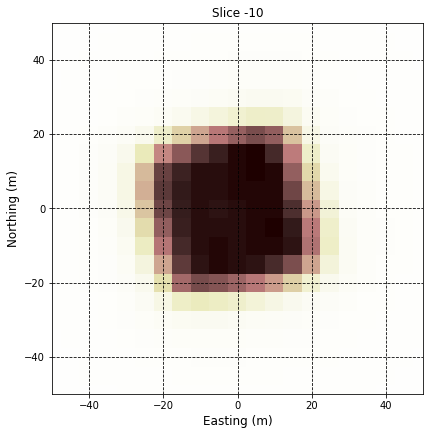

In [75]:
# Mesh.TensorMesh.writeModelUBC(mesh,'Invmodel.sus',mrec_ROT)
xlim = [-50,50]
ylim = [-50,50]
zlim = [-110,0]
indz = -10
indy = 25
vmin, vmax = 0, 0.075

fig = plt.figure(figsize=(12,12))

for ii, model in enumerate(mrec):
    axs = plt.subplot(2,2,ii+1)
    im = mesh.plotSlice(model, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
    axs.set_aspect('equal')
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    im[0].vmin=vmin
    im[0].vmax=vmax
    im[0].clim=([vmin,vmax])
    axs.grid(True, color='k', linestyle='--')
#     axs.set_title(r'$\theta\;=\;'+ str(angle) + '^\circ$')
    axs.set_xlabel('Easting (m)', size=12)
    pos = axs.get_position()
    axs.set_ylabel('Northing (m)', size=12)
    axs.set_position([pos.x0-.03, pos.y0-0.05, pos.width*1.25, pos.height*1.25])

plt.show()

In [80]:

theta = np.deg2rad(0.)
phi = np.deg2rad(30.)

indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.F.shape[1])
for ii in range(survey.nD):
    wr += (prob.F[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg1.norms = norms
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg2.norms = norms
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+5)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10)
update_Jacobi = Directives.UpdateJacobiPrecond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec30 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+05  6.22e+04  2.62e-06  6.22e+04    2.84e+02      0              
   1  5.00e+04  9.91e+01  1.32e-02  7.60e+02    2.33e+02      0              
   2  2.50e+04  2.84e+01  1.42e-02  3.83e+02    1.98e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.010459777070104204 eps_q: 0.010459777070104204
Eps_p: 0.010459777070104204
Eps_q: 0.010459777070104204
delta phim: 9.437e+03
   3  1.25e+04  7.69e+00  2.94e-02  3.75e+02    1.81e+02      0   Skip BFGS  
Beta search step: 0.813754834995228

In [81]:
theta = np.deg2rad(0.)
phi = np.deg2rad(45.)

indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.F.shape[1])
for ii in range(survey.nD):
    wr += (prob.F[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg1.norms = norms
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg2.norms = norms
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+5)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10)
update_Jacobi = Directives.UpdateJacobiPrecond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec45 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+05  6.22e+04  2.62e-06  6.22e+04    2.84e+02      0              
   1  5.00e+04  9.91e+01  1.32e-02  7.60e+02    2.32e+02      0              
   2  2.50e+04  2.84e+01  1.42e-02  3.83e+02    1.98e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.010459784539275211 eps_q: 0.010459784539275211
Eps_p: 0.010459784539275211
Eps_q: 0.010459784539275211
delta phim: 9.437e+03
   3  1.25e+04  7.69e+00  2.94e-02  3.75e+02    1.81e+02      0   Skip BFGS  
Beta search step: 0.81276030954593


In [83]:
theta = np.deg2rad(0.)
phi = np.deg2rad(75.)
indActive = np.zeros(mesh.nC, dtype=bool)
indActive[actv] = True

# This is for the aircells
Pac = Utils.speye(mesh.nC)[:, indActive]

Dx1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X') * Pac
Dy1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y') * Pac
Dz1 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z') * Pac

Dx2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'X', forward=False) * Pac
Dy2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Y', forward=False) * Pac
Dz2 = Pac.T * getDiffOpRot(mesh, np.deg2rad(0.), theta, phi, 'Z', forward=False) * Pac

# Inversion
wr = np.zeros(prob.F.shape[1])
for ii in range(survey.nD):
    wr += (prob.F[ii, :]/survey.std[ii])**2. 

wr = (wr/np.max(wr))
wr = wr**0.5

prob.unpair()
survey.pair(prob)

actv = np.ones(mesh.nC, dtype='bool')
# Create a regularization
reg1 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg1.norms = norms
reg1.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg1.objfcts[1].regmesh._cellDiffxStencil = Dx1
reg1.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg1.objfcts[2].regmesh._cellDiffyStencil = Dy1
reg1.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg1.objfcts[3].regmesh._cellDiffzStencil = Dz1
reg1.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg2 = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='components')
reg2.norms = norms
reg2.cell_weights = wr#driver.cell_weights*mesh.vol**0.5

reg2.objfcts[1].regmesh._cellDiffxStencil = Dx2
reg2.objfcts[1].regmesh._aveCC2Fx = speye(mesh.nC)

reg2.objfcts[2].regmesh._cellDiffyStencil = Dy2
reg2.objfcts[2].regmesh._aveCC2Fy = speye(mesh.nC)

reg2.objfcts[3].regmesh._cellDiffzStencil = Dz2
reg2.objfcts[3].regmesh._aveCC2Fz = speye(mesh.nC)

reg= reg1

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=-1, upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta=1e+5)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=1, maxIRLSiter=10)
update_Jacobi = Directives.UpdateJacobiPrecond()

inv = Inversion.BaseInversion(invProb,
                              directiveList=[IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(mesh.nC)*1e-4  # Starting model
prob.model = m0
mrec60 = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+05  6.22e+04  2.62e-06  6.22e+04    2.84e+02      0              
   1  5.00e+04  9.91e+01  1.32e-02  7.60e+02    2.33e+02      0              
   2  2.50e+04  2.84e+01  1.42e-02  3.83e+02    1.98e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.010459770983136177 eps_q: 0.010459770983136177
Eps_p: 0.010459770983136177
Eps_q: 0.010459770983136177
delta phim: 9.437e+03
   3  1.25e+04  7.69e+00  2.94e-02  3.76e+02    1.81e+02      0   Skip BFGS  
Beta search step: 0.813001949669588

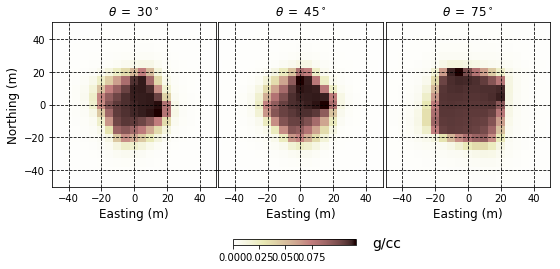

In [84]:
figName = 'Lp_2ptGrad.png'

# Mesh.TensorMesh.writeModelUBC(mesh,'Invmodel.sus',mrec_ROT)
xlim = [-50,50]
ylim = [-50,50]
zlim = [-110,0]
indz = -10
indy = 25
vmin, vmax = 0, 0.075

fig = plt.figure(figsize=(8,4))
axs = plt.subplot(1,3,1)
im = mesh.plotSlice(mrec30, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.grid(True, color='k', linestyle='--')
axs.set_title(r'$\theta\;=\;30^\circ$')
axs.set_xlabel('Easting (m)', size=12)
pos = axs.get_position()
axs.set_ylabel('Northing (m)', size=12)
axs.set_position([pos.x0-.03, pos.y0-0.05, pos.width*1.25, pos.height*1.25])

axs = plt.subplot(1,3,2)
im = mesh.plotSlice(mrec45, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.set_title(r'$\theta\;=\;45^\circ$')
axs.set_yticklabels([])
axs.set_ylabel('')
axs.grid(True, color='k', linestyle='--')
axs.set_xlabel('Easting (m)', size=12)
pos = axs.get_position()
axs.set_position([pos.x0-0.015, pos.y0-0.05, pos.width*1.25, pos.height*1.25])

pos = axs.get_position()
axbar = plt.axes([pos.x0+0.025, pos.y0-0.1,  pos.width*.75, pos.height*.75])
cbar = plt.colorbar(im[0], orientation='horizontal',format='%.3f')
cbar.set_ticks(np.linspace(vmin,vmax,4))
axbar.text(pos.x0+0.75, pos.y0-.35,'g/cc', size=14)
axbar.axis('off')


axs = plt.subplot(1,3,3)
im = mesh.plotSlice(mrec60, normal='Z', ind=indz, ax=axs, pcolorOpts={'cmap':'pink_r','clim':[vmin,vmax]})
axs.set_aspect('equal')
axs.set_xlim(xlim)
axs.set_ylim(ylim)
im[0].vmin=vmin
im[0].vmax=vmax
im[0].clim=([vmin,vmax])
axs.set_title(r'$\theta\;=\;75^\circ$')
axs.set_yticklabels([])
axs.set_ylabel('')
axs.grid(True, color='k', linestyle='--')

pos = axs.get_position()
axs.set_xlabel('Easting (m)', size=12)
axs.set_position([pos.x0+0.0025, pos.y0-0.05, pos.width*1.25, pos.height*1.25])




           

plt.show()

fig.savefig(figName)

In [69]:
from ipywidgets import widgets


def GradSlicer(mesh, model):

    
    def plotIt(orientation,psi,theta,phi,vec,view):
    

    
        Gx = getDiffOpRot(mesh, np.deg2rad(psi), np.deg2rad(theta), np.deg2rad(phi), vec, forward=orientation)

        I, J , V = sp.sparse.find(Gx)
        indx = I == int(mesh.nC/2)
        gradM = np.zeros(mesh.nC)
        gradM[J[indx]] = V[indx]
        
        ax = mesh.plotSlice(gradM, ind=1, normal=view,pcolorOpts={'cmap':
                                                                 'Greys'}, grid=True)
        plt.colorbar(ax[0])
        plt.show()
        
    out = widgets.interactive(plotIt,                              
                              orientation = widgets.Dropdown(options={'Forward': True, 'Backward': False},value=True,description='Orientation:'),
                              psi = widgets.FloatSlider(min=-90, max=90, step=1,value=0, continuous_update=False),
                              theta = widgets.FloatSlider(min=-90, max=90, step=1,value=0, continuous_update=False),
                              phi = widgets.FloatSlider(min=-180, max=180, step=1,value=0, continuous_update=False),
                              vec = widgets.RadioButtons(options=['X', 'Y', 'Z'], value='X', description='Vector:',disabled=False),
                              view = widgets.RadioButtons(options=['X', 'Y', 'Z'], value='X', description='Normal:',disabled=False)
                             )

    return out

mesh = Mesh.TensorMesh([np.ones(3),np.ones(3),np.ones(3)], x0='CCC')
model = np.zeros((mesh.nC,1))
model[int(mesh.nC/2)] = 1

GradSlicer(mesh, model)

interactive(children=(Dropdown(description='Orientation:', options={'Forward': True, 'Backward': False}, value…

NameError: name 'Dx1' is not defined

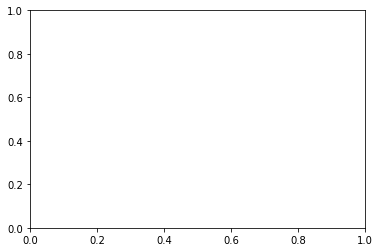

In [38]:
axs = plt.subplot()
plt.hist(np.abs(Dx1*IRLS.l2model),200)
# plt.hist(np.abs(Dx1*mrec),200)
axs.set_xlim(0,0.002)
plt.show()

In [68]:
reg = Regularization.Sparse(mesh)

# Get elements along Gx
Ix, Jx, Vx = sp.sparse.find(reg.objfcts[0].regmesh.cellDiffxStencil)

# Get elements along Gy
Iy, Jy, _ = sp.sparse.find(reg.objfcts[0].regmesh.cellDiffyStencil)

# Get elements along Gz
Iz, Jz, _ = sp.sparse.find(reg.objfcts[0].regmesh.cellDiffzStencil)

ix, iy, iz = Ix[1::2], Iy[1::mesh.vnC[0]], Iz[1::int(mesh.vnC[0]*mesh.vnC[1])]
jx, jy, jz = Jx[1::2], Jy[1::mesh.vnC[0]], Jz[1::int(mesh.vnC[0]*mesh.vnC[1])]
# jx2, jy2, jz2 = Jx[1::2], Jy[1::2], Jz[1::2]

print(Iy, Jy)
# Gxy = sp.sparse.csr_matrix([Ix,Jx], Vx, mesh.nC, mesh.nC)

[ 3  4  5  3  6  4  7  5  8  6  7  8 15 16 17 15 18 16 19 17 20 18 19 20
 27 28 29 27 30 28 31 29 32 30 31 32] [ 0  1  2  3  3  4  4  5  5  6  7  8  9 10 11 12 12 13 13 14 14 15 16 17
 18 19 20 21 21 22 22 23 23 24 25 26]


In [64]:
mesh.nC[0]


TypeError: 'int' object is not subscriptable

In [41]:
# Forward grad xy
jxy = np.zeros_like(jx)
jy[iy in jx]

array([[ 0,  2,  3,  4,  5,  7,  9, 11, 12, 13, 14, 16, 18, 20, 21, 22,
        23, 25]], dtype=int32)

In [43]:
iy

array([ 3,  5,  6,  7,  8,  7, 15, 17, 18, 19, 20, 19, 27, 29, 30, 31, 32,
       31], dtype=int32)